In [1]:
from dzdy import *

par_script = """
    transmission_rate = 1.5
    rec_rate ~ triangle(0.1, 0.2, 0.3)
    beta ~ exp(transmission_rate)
    gamma ~ exp(rec_rate)
    Die ~ exp(0.02)
"""

dc_ctbn_script = '''
    Name = SIR_bn
    Type = CTBN
    
    life[Alive | Dead]
    sir[S | I | R]
    
    Alive{life:Alive}
    Dead{life:Dead}
    Inf{life:Alive, sir:I}
    Rec{life:Alive, sir:R}
    Sus{life:Alive, sir:S}

    Die -> Dead # from transition Die to state Dead by distribution Die
    Sus -- Infect(beta) -> Inf 
    Inf -- Recov(gamma) -> Rec
    
    Alive -- Die # from state Alive to transition Die
'''

da = DirectorABM()
da.read_pcore('pSIR', par_script)
da.read_dcore(dc_ctbn_script)
cfd = da.new_abm('ABM_SIR', 'pSIR', 'SIR_bn')
cfd.add_fill_up('Distribution', Name = 'BMI', Distribution = 'norm(23,5)')

cfd.add_network('IDU', 'BA', m=2)
cfd.add_behaviour('cycle', be_type='Reincarnation', s_birth = 'Sus', s_death = 'Dead')
cfd.add_behaviour('transmission', be_type='NetShock', s_src = 'Inf', t_tar = 'Infect', net='')

cfd.set_observations(states=['Sus', 'Inf', 'Rec'], 
                      behaviours=['transmission'])


PCore pSIR added
Dcore SIR_bn added


def copy_agent(ag_src, dc_new, tr_ch=None):
    if not tr_ch:
        tr_ch = dc_new.Transitions
    ag_new = Agent(ag_src.Name, dc_new[ag_src.State.Name])

    if not tr_ch:
        return ag_new
    
    for tr, tte in ag_src.Trans.items():
        if tr.Name in tr_ch:
            continue
        ag_new.Trans[dc_new.Transitions[tr.Name]] = tte
    ag_new.Info.update(ag_src.Info)  
    return ag_new

def copy_abm(mod_src, mc, tr_tte=True, pc_new=None):
    mod_new = da.generate_abm(mc)
    time_copy = mod_src.TimeEnd if mod_src.TimeEnd else 0
    mod_new.TimeEnd = mod_src.TimeEnd
    if pc_new:
        mod_new.PCore = pc_new
    else:
        pc_new = mod_new.PCore
    dc_new = mod_new.DCore
    trs = da.get_dcore(da.MCores[mc].TargetedDCore).Transitions
    ags_src = mod_src.Pop.Agents
    if tr_tte:
        _, ds = pc_new.difference(mod_src.PCore)
        tr_ch = [k for k, v in trs.items() if v['Dist'] in ds]
        print('Changed transitions: {}'.format(', '.join(tr_ch)))
        for k, v in ags_src.items():
            mod_new.Pop.Agents[k] = copy_agent(v, dc_new, tr_ch)
    else:
        for k, v in ags_src.items():
            mod_new.Pop.Agents[k] = copy_agent(v, dc_new)

    mod_new.Pop.Eve.Last = mod_src.Pop.Eve.Last

    ags_new = mod_new.Pop.Agents
    mod_new.Pop.Networks.match(mod_src.Pop.Networks, ags_new)

    for be_src, be_new in zip(mod_src.Behaviours.values(), mod_new.Behaviours.values()):
        be_new.match(be_src, ags_src, ags_new, time_copy)

    for ag in mod_new.agents:
        ag.update(time_copy)
    return mod_new    

In [2]:
import matplotlib.pyplot as plt

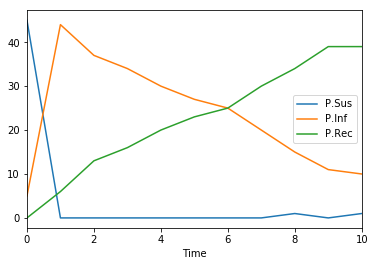

In [3]:
mod_src = da.generate_abm('ABM_SIR')
out_src = simulate(mod_src, y0={'Sus': 45, 'Inf': 5}, fr=0, to=10)
out_src.plot()
plt.show()

Changed transitions: Recov


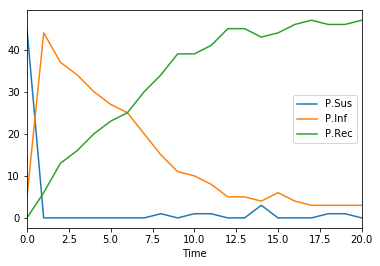

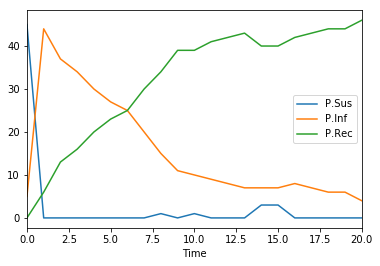

In [4]:
mod_new = da.copy_abm(mod_src, 'ABM_SIR')
out_src = update(mod_src, 20)
out_src.plot()
out_new = update(mod_new, 20)
out_new.plot()
plt.show()